# Social Logistic Regression and Random Forest Models Using Merged Data Experiment 2.2

In [1]:
import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import csv
import pickle
import warnings
import stanza

from random import shuffle
from nltk import word_tokenize,pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from collections import Counter
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, r2_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Set random seed
random.seed(18)
seed = 18

# Ignore warnings
warnings.filterwarnings('ignore')

# Display options
pd.set_option('display.max_colwidth', None)

# Initialize lemmatizer, stop words, and stanza
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
stanza.download('en') # download English model
nlp = stanza.Pipeline('en') # initialize English neural pipeline


2024-10-16 09:01:25 INFO: Downloaded file to /Users/gbaldonado/stanza_resources/resources.json
2024-10-16 09:01:25 INFO: Downloading default packages for language: en (English) ...
2024-10-16 09:01:27 INFO: File exists: /Users/gbaldonado/stanza_resources/en/default.zip
2024-10-16 09:01:29 INFO: Finished downloading models and saved to /Users/gbaldonado/stanza_resources
2024-10-16 09:01:29 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-10-16 09:01:29 INFO: Downloaded file to /Users/gbaldonado/stanza_resources/resources.json
2024-10-16 09:01:30 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2024-10-16 09:01:30 INFO: Using device: cpu
2024-10-16 09:01:30 INFO: Loading: tokenize
2024-10-16 09:01:30 INFO: Loading: mwt
2024-10-16 09:01:30 INFO: Loading: pos
2024-10-16 09:01:31 INFO: Loading: lemma
2024-10-16 09:01:31 INFO: Loading: constituency
2024-10-16 09:01:31 INFO: Loading: depparse
2024-10-16 09:01:31 INFO: Loading: sentiment
2024-10-16 09:01:31 INFO: Loading: 

## 1. Loading the data and quick exploratory data analysis

In [2]:
merged_social_df_batch_1 = pd.read_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/processed_for_model/merged_themes_using_jaccard_method/merged_Social_sentence_level_batch_1_jaccard.csv", encoding='utf-8')
merged_social_df_batch_2 = pd.read_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/processed_for_model/merged_themes_using_jaccard_method/Social Plus_sentence_level_batch_2_jaccard.csv", encoding='utf-8')

merged_social_df = pd.concat([merged_social_df_batch_1, merged_social_df_batch_2])


seed = 18
# Shuffle the merged dataset
merged_social_df = shuffle(merged_social_df, random_state=seed)

# Function for undersampling or oversampling
def resample_data(X, y, strategy='oversample', random_state=seed):
    """
    Resample the data using either undersampling or oversampling.

    Parameters:
    - X: Features
    - y: Labels
    - strategy: 'oversample' or 'undersample'
    - random_state: Seed for reproducibility

    Returns:
    - X_resampled, y_resampled: Resampled data and labels
    """
    if strategy == 'oversample':
        sampler = RandomOverSampler(random_state=random_state)
    elif strategy == 'undersample':
        sampler = RandomUnderSampler(random_state=random_state)
    else:
        raise ValueError("Strategy must be 'oversample' or 'undersample'")

    X_resampled, y_resampled = sampler.fit_resample(X, y)
    return X_resampled, y_resampled

# Separate features and labels
X = merged_social_df.drop(columns=['label'])  # Replace 'label' with your target column name
y = merged_social_df['label']

# Toggle resampling
resample = True  # Set this to False to turn off resampling

if resample:
    # Apply resampling (choose 'oversample' or 'undersample')
    X_resampled, y_resampled = resample_data(X, y, strategy='oversample', random_state=seed)

    # Combine resampled data into a single DataFrame
    resampled_df = pd.concat([X_resampled, y_resampled], axis=1)
else:
    # No resampling, use original dataset
    resampled_df = merged_social_df

# Train-test split
training_df, test_df = train_test_split(resampled_df, test_size=0.1, random_state=18, stratify=resampled_df['label'])


# # Train-test split
training_df, test_df = train_test_split(resampled_df, test_size=0.1, random_state=18, stratify=resampled_df['label'])

training_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print("Training and test sets loaded.")

Training and test sets loaded.


In [3]:
print(f"Training dataset shape: {training_df.shape} \nTest dataset shape: {test_df.shape}")
pos_labels = len([n for n in training_df['label'] if n==1])
print("Positive labels present in the dataset : {}  out of {} or {}%".format(pos_labels, len(training_df['label']), (pos_labels/len(training_df['label']))*100))
pos_labels = len([n for n in test_df['label'] if n==1])
print("Positive labels present in the test dataset : {}  out of {} or {}%".format(pos_labels, len(test_df['label']), (pos_labels/len(test_df['label']))*100))

Training dataset shape: (5464, 3) 
Test dataset shape: (608, 3)
Positive labels present in the dataset : 2732  out of 5464 or 50.0%
Positive labels present in the test dataset : 304  out of 608 or 50.0%


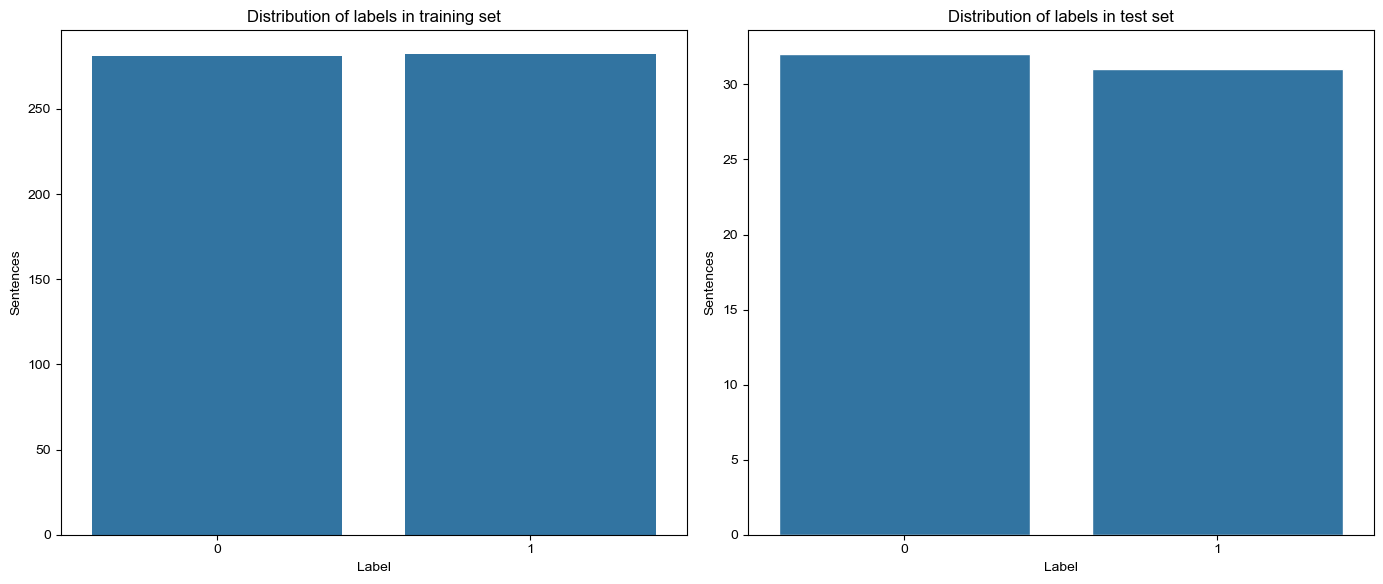

In [4]:
# Generate the data for the plots
training_counts = training_df['label'].value_counts()
test_counts = test_df['label'].value_counts()

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for the training set
sns.barplot(x=training_counts.index, y=training_counts.values, ax=axes[0])
axes[0].set_title('Distribution of labels in training set')
axes[0].set_ylabel('Sentences')
axes[0].set_xlabel('Label')
sns.set(style="whitegrid")

# Plot for the test set
sns.barplot(x=test_counts.index, y=test_counts.values, ax=axes[1])
axes[1].set_title('Distribution of labels in test set')
axes[1].set_ylabel('Sentences')
axes[1].set_xlabel('Label')
sns.set(style="whitegrid")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

## 2. Feature Engineering

### 1. NER

In [5]:
def get_ner(text):
    ner_list = []
    # Annotate the text using stanza
    doc = nlp(text)

    for sentence in doc.sentences:
        for entity in sentence.ents:
            if entity.type == 'PERSON':
                ner_list.append(entity.text)

    return ner_list

# Example usage
text = "Barack Obama was the 44th doctor of the United States."
print(get_ner(text))

['Barack Obama']


In [6]:
# check if a named entity is present in the sentence
def named_entity_present(sentence):
    ner_list = get_ner(sentence)
    if len(ner_list) > 0:
        return 1
    else:
        return 0

### 2. Similarity Features

In [7]:
# A helper function to get the similar words and similarity score
# The function takes tokens of sentence as input and if its not a stop word, get its similarity with synsets of STEM.
stop_words = set(stopwords.words('english'))
stop_words |= set(["help","try", "work", "process", "support", "job"] )
def word_similarity(tokens, syns, field):    
    if field in ['engineering', 'technology']:
        score_threshold = 0.5
    else:
        score_threshold = 0.2
    sim_words = 0
    for token in tokens:
        if token not in stop_words:
            try:
                syns_word = wordnet.synsets(token) 
                score = syns_word[0].path_similarity(syns[0])
                if score >= score_threshold:
                    sim_words += 1
            except: 
                score = 0
    
    return sim_words

In [8]:
# Functions to create columns for similarity based on all STEM fields
syns_bio = wordnet.synsets(lemmatizer.lemmatize("biology"))
syns_maths = wordnet.synsets(lemmatizer.lemmatize("mathematics")) 
syns_tech = wordnet.synsets(lemmatizer.lemmatize("technology"))
syns_eng = wordnet.synsets(lemmatizer.lemmatize("engineering"))
syns_chem = wordnet.synsets(lemmatizer.lemmatize("chemistry"))
syns_phy = wordnet.synsets(lemmatizer.lemmatize("physics"))
syns_sci = wordnet.synsets(lemmatizer.lemmatize("science"))

### 3. Medical Word Count

In [9]:
# Load the medical specialization text file and create a list
medical_list = []
with open('/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/features/medical_specialities.txt', 'r') as medical_fields:
    for line in medical_fields.readlines():
        special_field = line.rstrip('\n')
        special_field = re.sub("\W"," ", special_field )
#         print(special_field)
        medical_list += special_field.split()
medical_list = list(set(medical_list))  
medical_list = [x.lower() for x in medical_list]
print(medical_list)

['male', 'blood', 'microbiology', 'ophthalmology', 'and', 'neurology', 'chemical', 'family', 'preventive', 'pulmonology', 'cardiothoracic', 'dermatopathology', 'neurophysiology', 'brain', 'ocular', 'gynecology', 'chest', 'gastroenterology', 'military', 'injury', 'diagnostic', 'consultation', 'neurourology', 'metabolism', 'breast', 'head', 'failure', 'health', 'anatomical', 'rehabilitation', 'palliative', 'radiology', 'reconstructive', 'disease', 'interventional', 'disabilities', 'uveitis', 'pediatrics', 'neuroradiology', 'neonatal', 'sports', 'advanced', 'addiction', 'clinical', 'aerospace', 'neuro', 'diseases', 'endocrinology', 'surgery', 'critical', 'mental', 'adolescent', 'maternal', 'procedural', 'dermatology', 'endovascular', 'physical', 'urology', 'neuropathology', 'occupational', 'orbit', 'anesthesiology', 'endocrinology', 'research', 'pulmonary', 'ophthalmology', 'internal', 'transplant', 'hepatology', 'critical', 'electrophysiology', 'neurodevelopmental', 'cytopathology', 'nep

In [10]:
# A helper function to get medical words
def check_medical_words(tokens):
    for token in tokens:
        if token not in stop_words and token in [x.lower() for x in medical_list]:
            return 1
        
    return 0

### 4. Sentiment Polarity and Subjectivity

In [11]:
# A helper function to get polarity and subjectivity of the sentence using TexBlob
def get_sentiment(sentence):
    sentiments =TextBlob(sentence).sentiment
    polarity = sentiments.polarity
    subjectivity = sentiments.subjectivity
    return polarity, subjectivity

### 5. POS Tag Count

In [12]:
# A helper function to get the count of POS tags of the sentence
def count_pos_tags(tokens):
    token_pos = pos_tag(tokens)
    count = Counter(tag for word,tag in token_pos)
    interjections =  count['UH']
    nouns = count['NN'] + count['NNS'] + count['NNP'] + count['NNPS']
    adverb = count['RB'] + count['RBS'] + count['RBR']
    verb = count['VB'] + count['VBD'] + count['VBG'] + count['VBN']
    determiner = count['DT']
    pronoun = count['PRP']
    adjetive = count['JJ'] + count['JJR'] + count['JJS']
    preposition = count['IN']
    return interjections, nouns, adverb, verb, determiner, pronoun, adjetive,preposition

In [13]:
def pos_tag_extraction(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)

### 6. Word Embeddings

In [14]:
# Load the w2v dict from pickle file
with open('/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/features/pickle/embeddings06122024.pickle', 'rb') as w2v_file:
    w2v_dict = pickle.load(w2v_file)

In [15]:
print("length of word embeddings: ", len(w2v_dict.keys()))

length of word embeddings:  4762


In [16]:
# Get the vectors for the essay
def vectorizer(sequence):
    vect = []
    numw = 0
    for w in sequence: 
        try :
            if numw == 0:
                vect = w2v_dict[w]
            else:
                vect = np.add(vect, w2v_dict[w])
            numw += 1
        except Exception as e:
            pass

    return vect/ numw 

In [17]:
# Function to split text into words
def split_into_words(text):
    return text.split()

### 7. Unigrams

In [18]:
# Define the vectorizer
unigram_vect = CountVectorizer(ngram_range=(1, 1), min_df=2, stop_words = 'english')

### 8. Putting them all together

In [19]:
# Wrapper function for feature engineering
def feature_engineering(original_dataset):

    dataset = original_dataset.copy()
    # create a new column with sentence tokens
    dataset['tokens'] = dataset['sentence'].apply(word_tokenize)
    # 1. Similarity features
    # biology
    dataset['bio_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_bio,'biology',)) 
    # chemistry
    dataset['chem_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_chem,'chemistry',))
    # physics
    dataset['phy_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_phy,'physics',))
    # mathematics
    dataset['math_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_maths,'mathematics',))
    # technology
    dataset['tech_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_tech,'technology',))
    # engineering
    dataset['eng_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_eng,'engineering',))
    
    # medical terms
    dataset['medical_terms'] = dataset['tokens'].apply(check_medical_words)
    
    # polarity and subjectivity
    dataset['polarity'], dataset['subjectivity'] = zip(*dataset['sentence'].apply(get_sentiment))
    
    # named entity recognition
    dataset['ner'] = dataset['sentence'].apply(named_entity_present)
    
    # pos tag count
    dataset = pos_tag_extraction(dataset, 'tokens', count_pos_tags, ['interjections', 'nouns', 'adverb', 'verb', 'determiner', 'pronoun', 'adjetive','preposition'])
    
    # labels
    data_labels = dataset['label']
    # X
    data_x = dataset.drop(columns='label')

    
    # vectorize all the essays
    vect_arr = data_x.tokens.apply(vectorizer)
    for index in range(0, len(vect_arr)):
        i = 0
        for item in vect_arr[index]:
            column_name= "embedding" + str(i)
            data_x.loc[index, column_name] = item
            i +=1
    
    return data_x,data_labels
    

In [20]:
X_train, y_train = feature_engineering(training_df)

In [21]:
X_train.shape

(563, 121)

In [22]:
y_train = y_train.astype('int')

In [23]:
X_test, y_test = feature_engineering(test_df)

In [24]:
X_test.shape

(63, 121)

In [25]:
y_test = y_test.astype('int')

**Calculate Unigram features for both train and test set**

In [26]:
X_train.shape

(563, 121)

In [27]:
X_test.shape

(63, 121)

In [28]:
X_train.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_2.1/Social/saved_features/X_train_final.csv", index=False)
X_test.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_2.1/Social/saved_features/X_test_final.csv", index=False)
y_train.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_2.1/Social/saved_features/y_train.csv", index=False)
y_test.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_2.1/Social/saved_features/y_test.csv", index=False)


In [29]:
# Unigrams for training set
unigram_matrix = unigram_vect.fit_transform(X_train['sentence'])
unigrams = pd.DataFrame(unigram_matrix.toarray())
print("Shape of the unigram df for train : ",unigrams.shape)
unigrams = unigrams.reset_index(drop=True)

Shape of the unigram df for train :  (563, 592)


In [30]:
X_train_final = pd.concat([X_train, unigrams], axis = 1)

In [31]:
X_train_final.columns = X_train_final.columns.astype(str)

In [32]:
X_train_final.shape

(563, 713)

In [33]:
unigram_matrix_test = unigram_vect.transform(X_test['sentence'])
unigrams_test = pd.DataFrame(unigram_matrix_test.toarray())
unigrams_test = unigrams_test.reset_index(drop=True)
print("Test unigram df shape : ",unigrams_test.shape)

Test unigram df shape :  (63, 592)


In [34]:
X_test_final = pd.concat([X_test, unigrams_test], axis = 1)
X_test_final.shape

(63, 713)

In [35]:
X_test_final.columns = X_test_final.columns.astype(str)

In [36]:
X_test_final.shape

(63, 713)

In [37]:
for i in range(0, len(X_train_final.columns)):
    print('{} ---- {}'.format(i, X_train_final.columns[i]))

0 ---- sentence
1 ---- phrase
2 ---- tokens
3 ---- bio_sim_words
4 ---- chem_sim_words
5 ---- phy_sim_words
6 ---- math_sim_words
7 ---- tech_sim_words
8 ---- eng_sim_words
9 ---- medical_terms
10 ---- polarity
11 ---- subjectivity
12 ---- ner
13 ---- interjections
14 ---- nouns
15 ---- adverb
16 ---- verb
17 ---- determiner
18 ---- pronoun
19 ---- adjetive
20 ---- preposition
21 ---- embedding0
22 ---- embedding1
23 ---- embedding2
24 ---- embedding3
25 ---- embedding4
26 ---- embedding5
27 ---- embedding6
28 ---- embedding7
29 ---- embedding8
30 ---- embedding9
31 ---- embedding10
32 ---- embedding11
33 ---- embedding12
34 ---- embedding13
35 ---- embedding14
36 ---- embedding15
37 ---- embedding16
38 ---- embedding17
39 ---- embedding18
40 ---- embedding19
41 ---- embedding20
42 ---- embedding21
43 ---- embedding22
44 ---- embedding23
45 ---- embedding24
46 ---- embedding25
47 ---- embedding26
48 ---- embedding27
49 ---- embedding28
50 ---- embedding29
51 ---- embedding30
52 ---- em

### LR Model 1: Unigrams, POS Tag Count, Sentiment Polarity, Subjectivity

In [47]:
from sklearn.metrics import classification_report, average_precision_score

In [49]:
X_train_model_1 = X_train_final.iloc[:,np.r_[10:12,13:21,121:712]]

In [50]:
X_train_model_1.shape

(563, 601)

In [51]:
X_test_model_1 = X_test_final.iloc[:,np.r_[10:12,13:21,121:712]]

In [52]:
X_test_model_1.shape

(63, 601)

In [53]:
model_1_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_1_pipeline, parameters, scoring="average_precision", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_1,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_1), digits=4))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.806
Best parameters set:
	clf__C: 1
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.6765    0.7188    0.6970        32
           1     0.6897    0.6452    0.6667        31

    accuracy                         0.6825        63
   macro avg     0.6831    0.6820    0.6818        63
weighted avg     0.6830    0.6825    0.6821        63



In [54]:
lr_model_1 = LogisticRegression(random_state=18, 
                                solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], 
                                class_weight='balanced').fit(X_train_model_1, y_train)
y_lr = lr_model_1.predict(X_test_model_1)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

# Calculate and print the average precision score
avg_precision = average_precision_score(y_test, y_lr)
print(f'Average Precision: {avg_precision:.4f}')

Logistic regression Classifier
True Negative: 23, False Positive: 9, False Negative: 11, True Positive: 20
--------------------------------------------------------------------------------
[[23  9]
 [11 20]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.72      0.70        32
           1       0.69      0.65      0.67        31

    accuracy                           0.68        63
   macro avg       0.68      0.68      0.68        63
weighted avg       0.68      0.68      0.68        63

Average Precision: 0.6195


### RF Model 1: Unigrams, POS Tag Count, Sentiment Polarity, Subjectivity

In [41]:
n_estimators = [10,20,50,100,200,300]
max_depth = [2,5,8,10,15,20]
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 5, 10,20]
rf_parameters = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
              min_samples_leaf = min_samples_leaf)

## reduced parameters
# n_estimators = [50, 100, 200]       # Reduced options
# max_depth = [5, 10, 15]             # Reduced options
# min_samples_split = [2, 10]         # Reduced options
# min_samples_leaf = [1, 5]           # Reduced options

# rf_parameters = dict(
#     n_estimators = n_estimators, 
#     max_depth = max_depth,  
#     min_samples_split = min_samples_split, 
#     min_samples_leaf = min_samples_leaf
# )


In [42]:
X_train_model_1 = X_train_final.iloc[:,np.r_[10:12,13:21,121:712]]

In [43]:
X_train_model_1.shape

(563, 601)

In [44]:
X_test_model_1 = X_test_final.iloc[:,np.r_[10:12,13:21,121:712]]

In [46]:
rf_model_1 = RandomForestClassifier(random_state=18,class_weight='balanced')
grid_search = GridSearchCV(rf_model_1, rf_parameters, scoring="average_precision", cv = 10, n_jobs=-1, verbose=1)
grid_search.fit(X_train_model_1,y_train)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(rf_parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_1), digits=2))

Fitting 10 folds for each of 900 candidates, totalling 9000 fits
Best score: 0.828
Best parameters set:
	max_depth: 15
	min_samples_leaf: 1
	min_samples_split: 20
	n_estimators: 200
              precision    recall  f1-score   support

           0       0.74      0.72      0.73        32
           1       0.72      0.74      0.73        31

    accuracy                           0.73        63
   macro avg       0.73      0.73      0.73        63
weighted avg       0.73      0.73      0.73        63



In [48]:
randomForest_1 = RandomForestClassifier(random_state=18,
                                        class_weight=best_parameters['class_weight'],
                                        max_depth=best_parameters['max_depth'],
                                        min_samples_leaf=best_parameters['min_samples_leaf'],
                                        min_samples_split=best_parameters['min_samples_split'],
                                        n_estimators=best_parameters['n_estimators']).fit(X_train_model_1, y_train)

y_lr = randomForest_1.predict(X_test_model_1)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

# Calculate and print the average precision score
avg_precision = average_precision_score(y_test, y_lr)
print(f'Average Precision: {avg_precision:.4f}')


Logistic regression Classifier
True Negative: 23, False Positive: 9, False Negative: 8, True Positive: 23
--------------------------------------------------------------------------------
[[23  9]
 [ 8 23]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.72      0.73        32
           1       0.72      0.74      0.73        31

    accuracy                           0.73        63
   macro avg       0.73      0.73      0.73        63
weighted avg       0.73      0.73      0.73        63

Average Precision: 0.6603
